In [1]:
from __future__ import absolute_import, division, print_function
from multiprocessing import Pool

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../../src/data/')

from config import *

In [3]:
#Dates that will be relevant
period_one = ['2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17',
    '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', 
    '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29']
period_two = ['2018-07-30', '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04', 
    '2018-08-05', '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10', 
    '2018-08-11', '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15']

all_dates = period_one + period_two

weekends = ['2018-06-16', '2018-06-17', '2018-06-23', '2018-06-24']

In [4]:
#Preparing the members and beacons metadata
members_metadata = pd.read_csv(members_metadata_path).set_index('member')
beacons_metadata = pd.read_csv(beacons_metadata_path).set_index('beacon')

In [5]:
#Preparing Dataframes to be used later
members_metadata_copy = members_metadata.reset_index()
hours_complied_period_one = pd.DataFrame(index = members_metadata_copy['member'])
hours_complied_period_two = pd.DataFrame(index = members_metadata_copy['member'])


Small functions that help filter the data

In [6]:
def get_closest_beacon(m5cb, members_metadata, beacons_metadata):
    """
    Parameters: dataframe, dataframe, dataframe
    Returns: a table with the closest beacon for each member
    """
    
    #Create table with only closest beacon
    m1cb = m5cb[['beacon_0', 'rssi_0']].rename(
        columns = {'beacon_0': 'beacon', 'rssi_0': 'rssi'}).reset_index()

    #Add beacon metadata
    m1cb = m1cb.join(
            beacons_metadata[['company', 'type']], on='beacon').rename(
            columns = {'company': 'beacon_company', 'type': 'beacon_type'})
    #Add badge metadata
    m1cb = m1cb.join(
            members_metadata[['company']], on='member').rename(columns = {'company': 'member_company'})
    
    return m1cb

In [7]:
def count_to_hours(counter):
    """
    Given a count
    Returns hours
    """
    seconds = counter*15
    minutes = seconds/60
    hours = minutes/60
    return(round(hours,2))

In [8]:
def drop_uncompliant(mySeries):
    return mySeries[mySeries.comply != False]

In [9]:
def drop_board_beacons(mySeries):
    """
    Given a dataframe
    Returns a dataframe without board beacons
    """
    return mySeries[mySeries.beacon_type != 'board']

Generating Dataframe of compliance hours for period one

In [10]:
for date in period_one:
    tempHours = pd.DataFrame()
    
    #Generate the Time Frame
    day_start = date + ' 00:00:00-04:00'
    day_end = date + ' 23:59:30-04:00'
    desired_range = "datetime >= day_start & datetime < day_end"
    
    #Preparing the closest beacon and compliance data
    m5cb = pd.read_hdf(clean_store_path,'proximity/member_5_closest_beacons', where = desired_range, data_columns= True)
    m1cb = get_closest_beacon(m5cb, members_metadata, beacons_metadata)
    
    comply_data = pd.read_hdf(analysis_store_path, '/proximity/member_comply', where = desired_range, data_columns= True)
    comply_dataframe = comply_data.to_frame()
    comply_dataframe.reset_index(inplace = True)
    
    m1cb = m1cb.merge(comply_dataframe, how = 'inner', on = ['datetime', 'member'])
    m1cb_comply = drop_uncompliant(m1cb)
    #m1cb_comply = drop_board_beacons(m1cb)
    
    grouped_compliance = m1cb_comply.groupby(['member'])

    daily_compliance_counts = grouped_compliance['comply'].count()
    tempHours[date] = daily_compliance_counts.apply(count_to_hours)
    
    hours_complied_period_one = hours_complied_period_one.join(tempHours)
    
    
    

Generating Dataframeof compliance hours for period two

In [11]:
for date in period_two:
    tempHours = pd.DataFrame()
    
    #Generate the Time Frame
    day_start = date + ' 00:00:00-04:00'
    day_end = date + ' 23:59:30-04:00'
    desired_range = "datetime >= day_start & datetime < day_end"
    
    #Preparing the closest beacon and compliance data
    m5cb = pd.read_hdf(clean_store_path,'proximity/member_5_closest_beacons', where = desired_range, data_columns= True)
    m1cb = get_closest_beacon(m5cb, members_metadata, beacons_metadata)
    
    comply_data = pd.read_hdf(analysis_store_path, '/proximity/member_comply', where = desired_range, data_columns= True)
    comply_dataframe = comply_data.to_frame()
    comply_dataframe.reset_index(inplace = True)
    
    m1cb = m1cb.merge(comply_dataframe, how = 'inner', on = ['datetime', 'member'])
    m1cb_comply = drop_uncompliant(m1cb)
    #m1cb_comply = drop_board_beacons(m1cb)
    
    grouped_compliance = m1cb_comply.groupby(['member'])

    daily_compliance_counts = grouped_compliance['comply'].count()
    tempHours[date] = daily_compliance_counts.apply(count_to_hours)
    
    hours_complied_period_two = hours_complied_period_two.join(tempHours)
    
    
    

In [12]:
#Cleaning the tables
hours_complied_period_one = hours_complied_period_one.fillna(0)
hours_complied_period_two = hours_complied_period_two.fillna(0)
hours_complied_period_one.sort_index(inplace = True)
hours_complied_period_two.sort_index(inplace = True)

2018-12-14 09:54:28,367 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


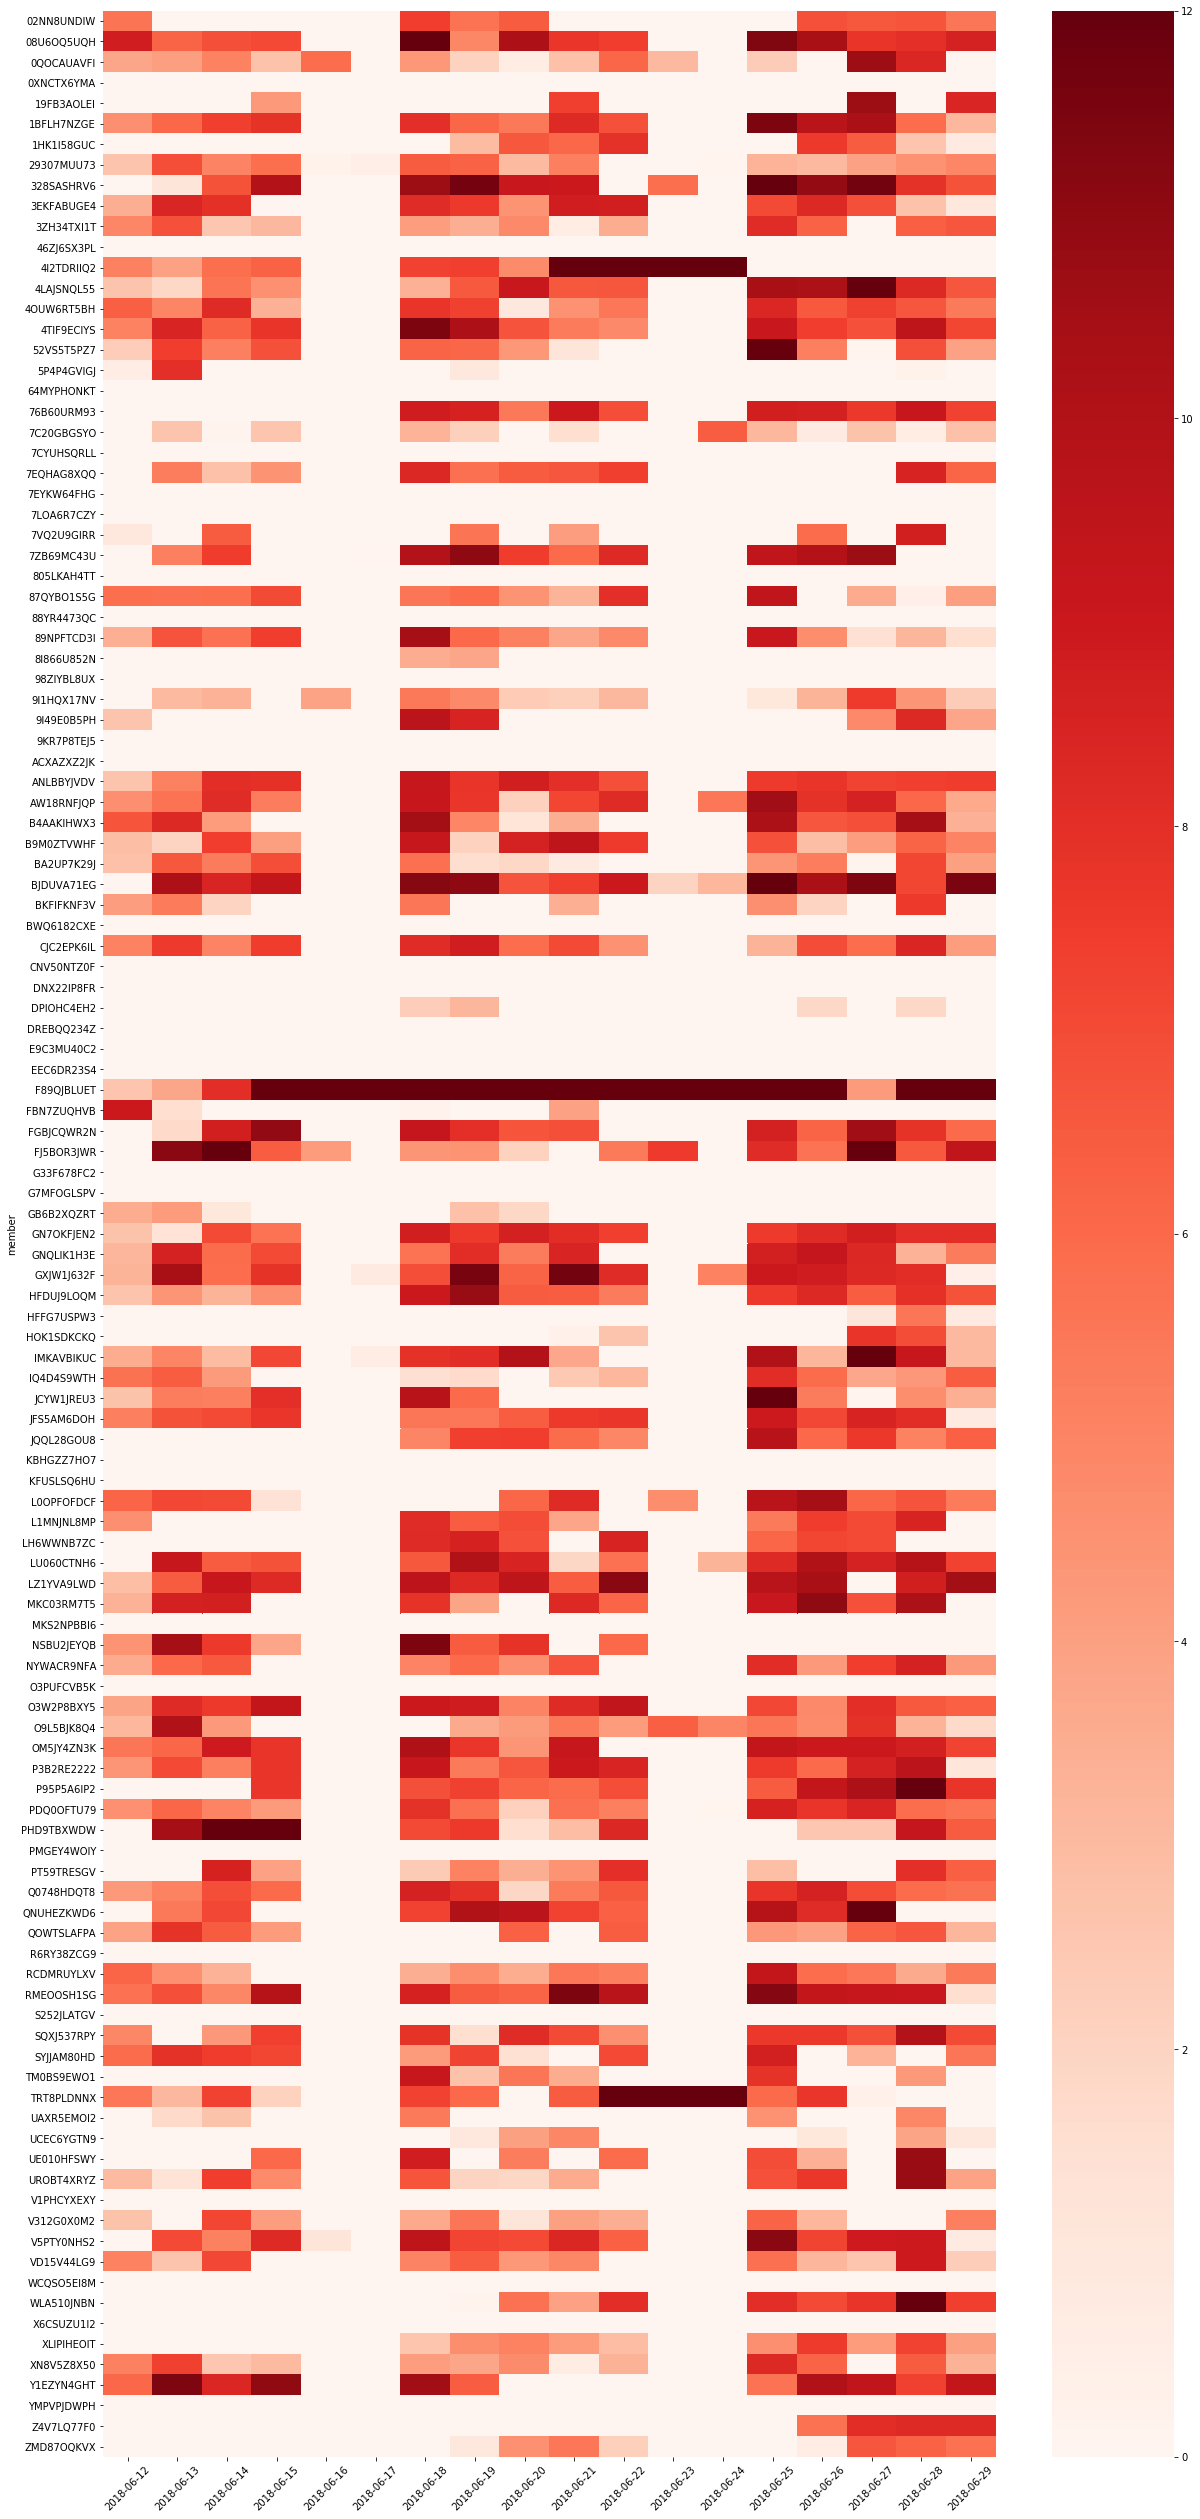

In [13]:
#Creating Period One Heatmap
plt.figure(figsize=(20,45))
sns.heatmap(hours_complied_period_one,cmap='Reds', vmax = 12, 
            cbar = True)
plt.xticks(rotation = 45)
plt.show()

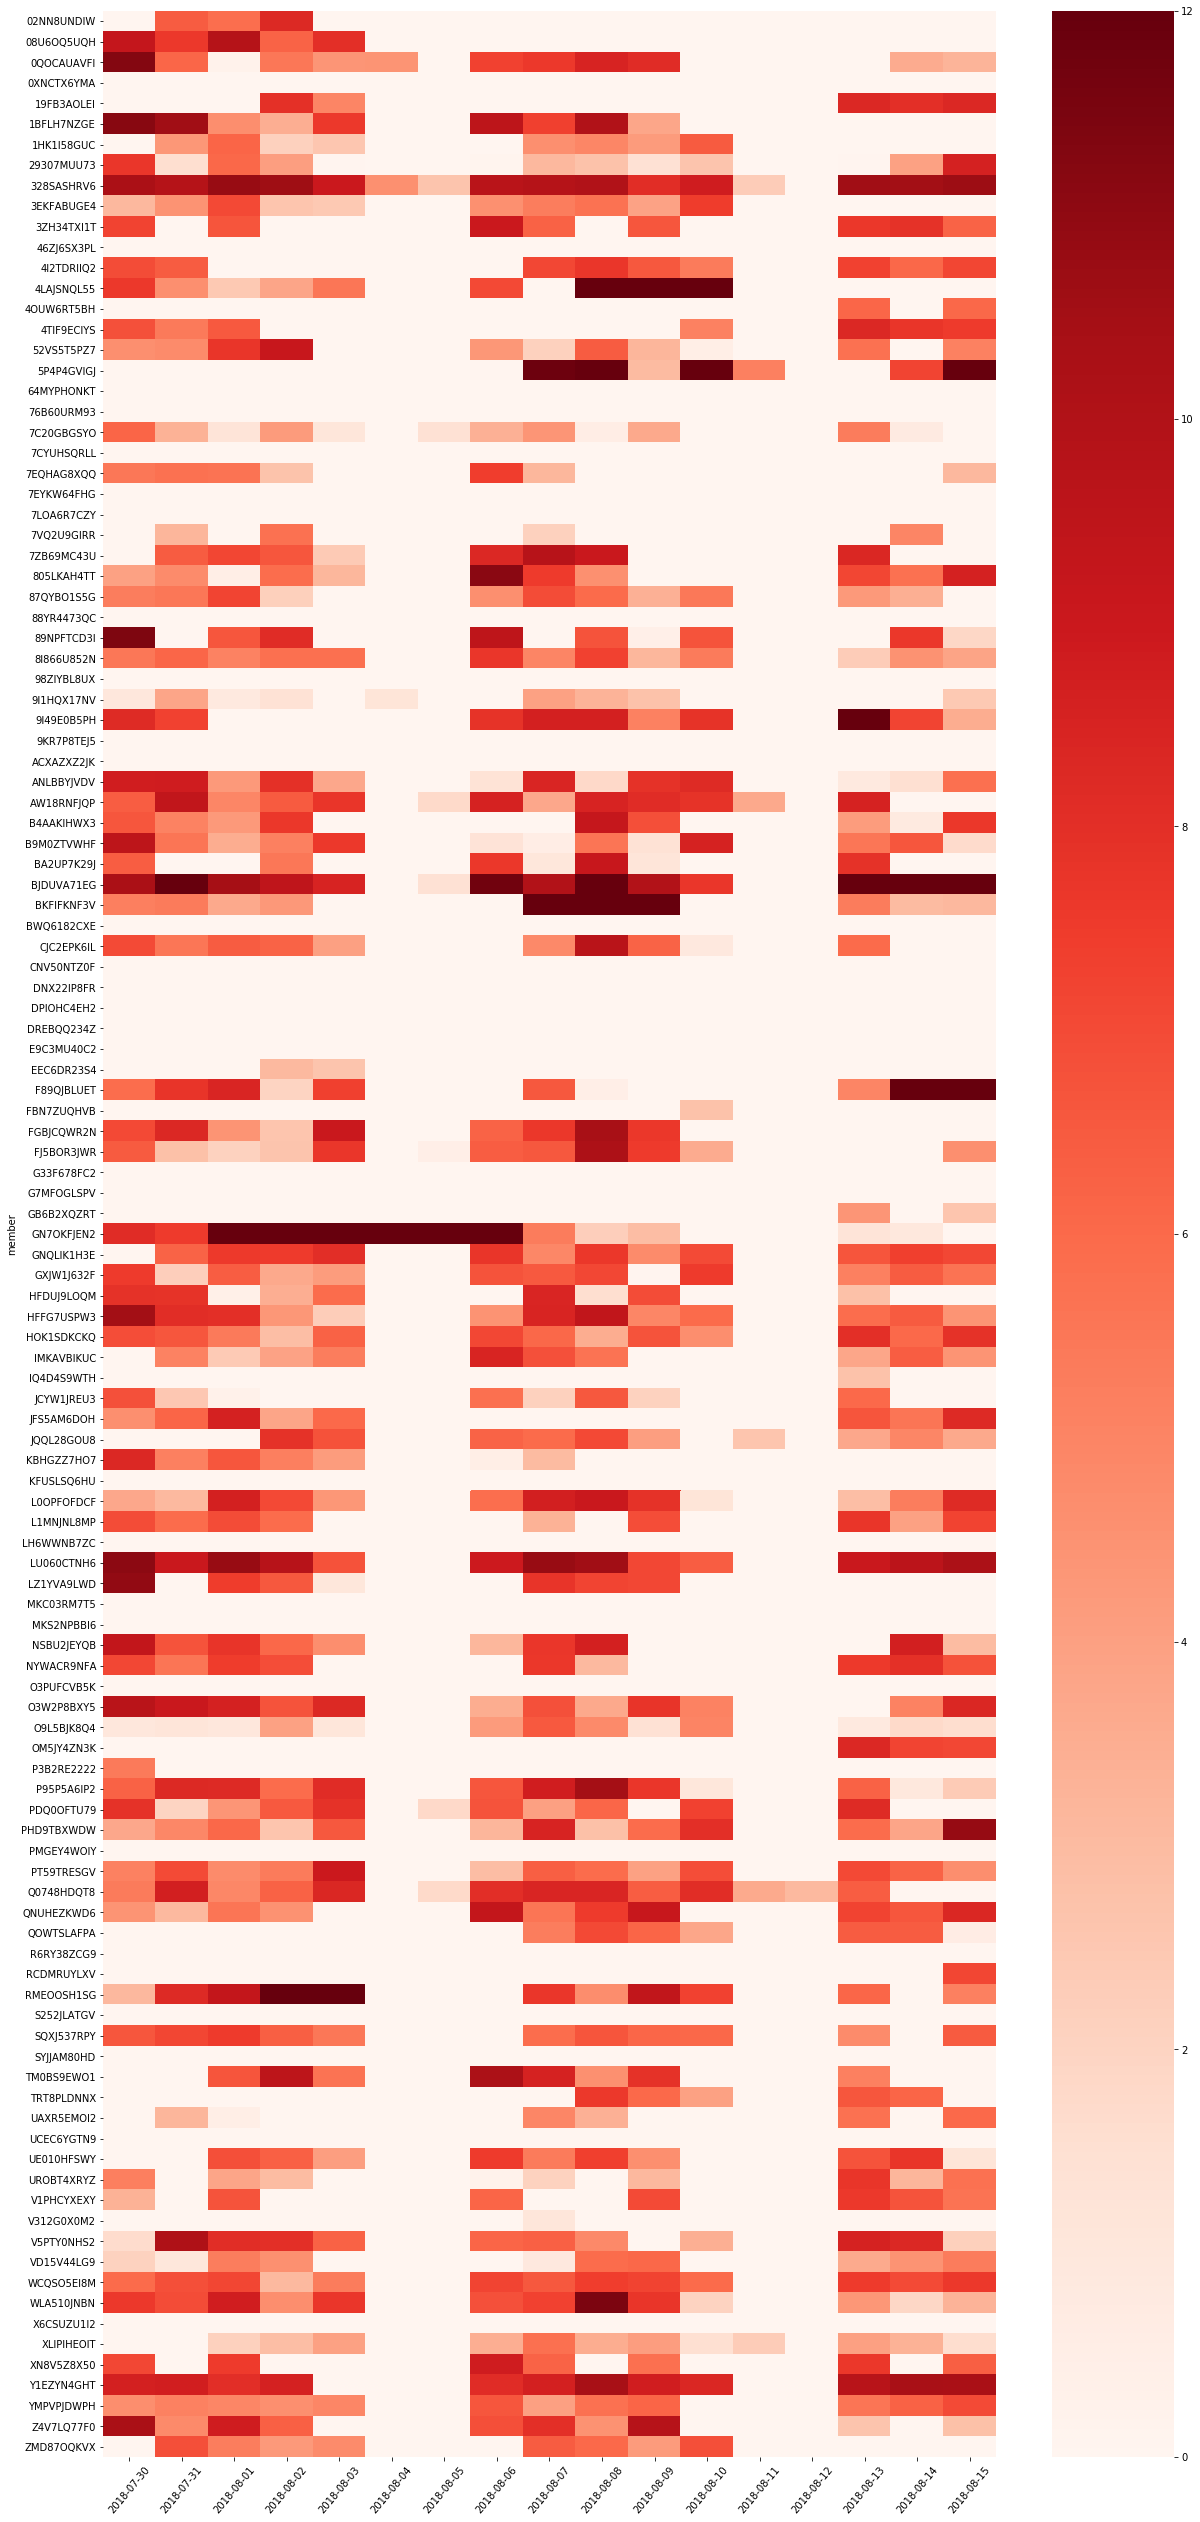

In [14]:
#Creating Period Two Heatmap
plt.figure(figsize=(20,45))
sns.heatmap(hours_complied_period_two,cmap='Reds', vmax = 12,
            cbar = True)
plt.xticks(rotation = 50)
plt.show()

In [15]:
#Appending to the tables
hours_complied_period_one['Total_Hours_Complied'] = hours_complied_period_one.sum(axis=1)
hours_complied_period_two['Total_Hours_Complied'] = hours_complied_period_two.sum(axis=1)

In [16]:
hours_complied_period_one.head()

,2018-06-12,2018-06-13,2018-06-14,2018-06-15,2018-06-16,2018-06-17,2018-06-18,2018-06-19,2018-06-20,2018-06-21,2018-06-22,2018-06-23,2018-06-24,2018-06-25,2018-06-26,2018-06-27,2018-06-28,2018-06-29,Total_Hours_Complied
member,,,,,,,,,,,,,,,,,,,
02NN8UNDIW,5.60,0.00,0.00,0.00,0.0,0.0,7.41,5.65,6.45,0.00,0.00,0.00,0.0,0.00,6.82,6.57,6.70,5.57,50.77
08U6OQ5UQH,8.77,6.19,6.85,7.05,0.0,0.0,12.15,4.88,10.13,7.72,7.43,0.00,0.0,11.38,10.35,7.77,7.99,8.59,117.25
0QOCAUAVFI,3.77,4.05,5.09,2.75,5.9,0.0,4.34,2.09,0.70,2.78,6.12,3.09,0.0,2.30,0.00,10.70,8.35,0.00,62.03
0XNCTX6YMA,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
19FB3AOLEI,0.00,0.00,0.00,4.22,0.0,0.0,0.00,0.00,0.00,7.39,0.00,0.00,0.0,0.00,0.01,10.68,0.00,8.41,30.71


In [17]:
hours_complied_period_two.head()

,2018-07-30,2018-07-31,2018-08-01,2018-08-02,2018-08-03,2018-08-04,2018-08-05,2018-08-06,2018-08-07,2018-08-08,2018-08-09,2018-08-10,2018-08-11,2018-08-12,2018-08-13,2018-08-14,2018-08-15,Total_Hours_Complied
member,,,,,,,,,,,,,,,,,,
02NN8UNDIW,0.00,6.45,5.82,8.25,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,20.52
08U6OQ5UQH,9.25,7.61,9.85,6.21,7.99,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,40.91
0QOCAUAVFI,11.29,6.13,0.26,5.51,4.36,4.41,0.0,7.31,7.6,8.5,8.11,0.0,0.0,0.0,0.00,3.60,3.25,70.33
0XNCTX6YMA,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00
19FB3AOLEI,0.00,0.00,0.00,7.95,4.98,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,8.32,8.01,8.34,37.60


In [18]:
member = '328SASHRV6'
hours_complied_period_two.loc[member]

2018-07-30               10.26
2018-07-31                9.88
2018-08-01               10.82
2018-08-02               10.61
2018-08-03                9.03
2018-08-04                4.58
2018-08-05                2.63
2018-08-06                9.70
2018-08-07                9.89
2018-08-08               10.01
2018-08-09                8.10
2018-08-10                8.84
2018-08-11                2.33
2018-08-12                0.00
2018-08-13               10.57
2018-08-14               10.52
2018-08-15               10.65
Total_Hours_Complied    138.42
Name: 328SASHRV6, dtype: float64